## This version uses the correct matrices in the linear equation. It however seems to give nearly indentical results to my previous version.

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [5]:
x = np.arange(-15, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

In [6]:
import scipy.stats

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = scipy.stats.multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

#g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1])
#plt.imshow(g1)

Make the two "images". `im1` is the template, `im2` is the science image.

NOTE: having sources near the edges really messes up the fitting (probably because of the convolution). So make sure no sources are near the edge.

NOTE: also it seems that having the variable source with a large flux increase also messes up the fitting (seems to lead to overfitting -- perhaps to the source itself). This might be fixed by adding more constant sources.

280 -0.187845065956 -11.0950094076
DescribeResult(nobs=261121, minmax=(-1499.5035483979973, 413.1833949903874), mean=0.028612505989967597, variance=3073.9678381644062, skewness=-9.063195631346078, kurtosis=127.29150488749946)


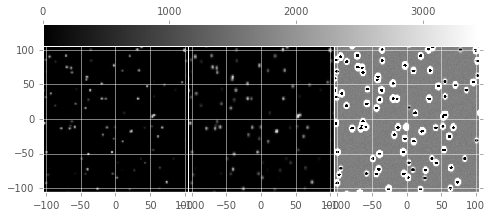

In [28]:
np.random.seed(66)

xim = np.arange(-255, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))
n_sources = 500
fluxes = np.random.uniform(50, 30000, n_sources)
xposns = np.random.uniform(xim.min()+5, xim.max()-5, n_sources)
yposns = np.random.uniform(yim.min()+5, yim.max()-5, n_sources)

# Make the source closest to the center of the image the one that increases in flux
ind = np.argmin(xposns**2. + yposns**2.)
print ind, xposns[ind], yposns[ind]

sig1 = 0.2  # sigma of template
sig2 = 0.2  # sigma of science image
im1 = np.random.normal(scale=sig1, size=x0im.shape)
im2 = np.random.normal(scale=sig2, size=x0im.shape)

psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image. make the psf in this image slighly offset and elongated
offset = 0.0  # 0.2  # astrometric offset in pixels between two images
for i in range(n_sources):
    im1 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i],yposns[i]], s=[psf1, psf1])
    im2 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i]+offset,yposns[i]+offset], s=[psf2, psf2*1.5])
    if i == ind:
        im2 += (fluxes[i]/1.) * gaussian2d(imgrid, m=[xposns[i]+0.2,yposns[i]+0.2], s=[psf2, psf2*1.5])

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (9, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow((im2-im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - im1, axis=None)

## Compute the FFTs for the "ZOGY" algorithm

In [29]:
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift

DescribeResult(nobs=261121, minmax=(-0.92719462140093301, 3903.8504029196174), mean=28.204319270672002, variance=27763.91842915089, skewness=8.910443938744283, kurtosis=95.51888434389336)
DescribeResult(nobs=261121, minmax=(-0.92719462140107078, 3903.8504029196174), mean=28.204319270672002, variance=27763.918429150883, skewness=8.910443938744287, kurtosis=95.5188843438934)


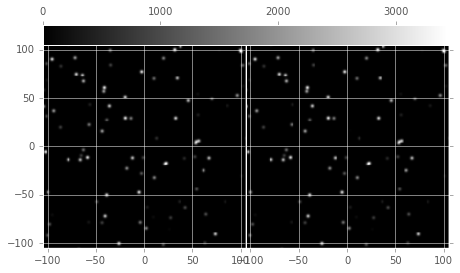

In [30]:
# First compute the science image's (im2's) psf -- easy since we parameterized it above when we made the image
im1_psf = gaussian2d(grid, m=[0, 0], s=[psf1, psf1])
im2_psf = gaussian2d(grid, m=[0, 0], s=[psf2, psf2*1.5])

im1_psf_ft = fft2(im1_psf)
im2_psf_ft = fft2(im2_psf)

im1_ft = fft2(im1)
im2_ft = fft2(im2)

# Just a sanity check:
fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(ifft2(im1_ft).real[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im1, axis=None)
print scipy.stats.describe(ifft2(im1_ft).real, axis=None)

### Now compute the ZOGY eqn. (13):

$$
\widehat{D} = \frac{F_r\widehat{P_r}\widehat{N} - F_n\widehat{P_n}\widehat{R}}{\sqrt{\sigma_n^2 F_r^2 |\widehat{P_r}|^2 + \sigma_r^2 F_n^2 |\widehat{P_n}|^2}}
$$

where $D$ is the optimal difference image, $R$ and $N$ are the reference and "new" image, respectively, $P_r$ and $P_n$ are their PSFs, $F_r$ and $F_n$ are their flux-based zero-points (which we will set to one here), $\sigma_r^2$ and $\sigma_n^2$ are their variance, and $\widehat{D}$ denotes the FT of $D$.

DescribeResult(nobs=261121, minmax=(-9.4410821694758855, 1822.8577406936372), mean=0.10116048506891936, variance=98.658706245009455, skewness=122.23780847685647, kurtosis=16913.396379033366)


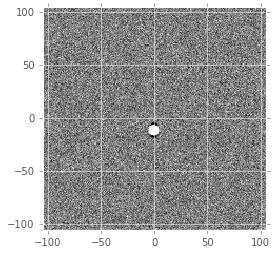

In [34]:
F_r = F_n = 1.
R_hat = fft2(im1)
N_hat = fft2(im2)
P_r = gaussian2d(imgrid, m=[0, 0], s=[psf1, psf1])
P_n = gaussian2d(imgrid, m=[0, 0], s=[psf2, psf2*1.5])
P_r_hat = fft2(P_r)
P_n_hat = fft2(P_n)
d_hat_numerator = (F_r * P_r_hat * N_hat - F_n * P_n_hat * R_hat)
d_hat_denom = np.sqrt((sig1**2 * F_r**2 * np.abs(P_r_hat)**2) + (sig2**2 * F_n**2 * np.abs(P_n_hat)**2))
d_hat = d_hat_numerator / d_hat_denom

d = ifft2(d_hat)
D = np.fft.ifftshift(d.real)
plt.imshow(D[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-4, 4))
print scipy.stats.describe(D, axis=None)

## Below for comparison is the image computed using L(ZOGY) from notebook #11.

1.0 1.37901446961 -0.0373581718091
DescribeResult(nobs=261121, minmax=(-6.665706677850328, 519.03212041112317), mean=0.028669030859421341, variance=8.0186388874028474, skewness=122.65313494207474, kurtosis=17021.459196098825)
DescribeResult(nobs=261121, minmax=(-0.89426981632092251, 450.33554171718959), mean=0.028658755319247373, variance=6.6425334090895882, skewness=115.92510407920047, kurtosis=15217.022162289448)


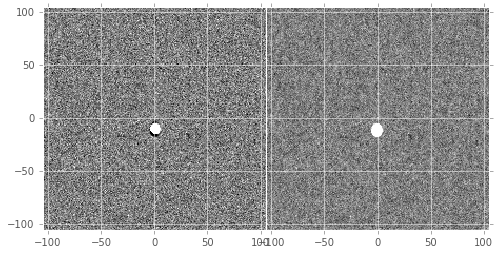

In [21]:
print pck.sum(), pck.max(), pck.min()
#pck /= pck.sum()
pci = scipy.ndimage.filters.convolve(im2-conv_im1, pck, mode='constant')

fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(pci[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1)) # corrected diffim
igrid[1].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1)) # original diffim
print scipy.stats.describe(pci, axis=None)
print scipy.stats.describe(im2 - conv_im1, axis=None)